In [11]:
import os
import numpy as np
import cv2
import json
from labelme import utils
from shapely.geometry import Polygon
from shapely.ops import unary_union
from labelme.utils.shape import shape_to_mask
from shapely.geometry import MultiPolygon
from PIL import Image
import shutil
import random
from pathlib import Path

## Prepare CMP Dataset

### Load dataset

CMP Facade Dataset was obtained from: https://cmp.felk.cvut.cz/~tylecr1/facade/
Including both the Base dataset ([CMP_facade_DB_base.zip](https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip) - 378 images) and the Extended dataset ([CMP_facade_DB_extended.zip](https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip) - 228 images)

In [2]:
#The original dataset includes three files per image: a .jpg image, a .png mask, and a .xml annotation file.
cmp_dataset="../training_images/cmp_dataset/all"

#We'll create a list of only the .png files(masks) in the cmp_dataset directory
cmp_png = [file for file in os.listdir(cmp_dataset) if file.endswith('.png')]

### Reclassify and aggregate existing classes: go from 12 to 3 classes

Originally, the CMP Facade dataset includes 12 classes, described in label_names.txt provided in the zip file of the dataset.

In [3]:
#Original class IDs
background_id = 1 #background
porosity_ids = [3, 4, 7, 8, 12] #window, door, balcony, blind, shop

#New directory to save the reclassified masks
output_folder = "../training_images/cmp_dataset/cmp_masks"
os.makedirs(output_folder, exist_ok=True)

#Reclassify classes
for file in cmp_png:
    # Cargar la máscara original
    mask_path = os.path.join(cmp_dataset, file)
    mask = np.array(Image.open(mask_path))

    #Create a new mask with the same shape as the original
    new_mask = np.zeros_like(mask, dtype=np.uint8)

    #Apply the new class IDs
    new_mask[mask == background_id] = 1 #new class for 'background' (class 1)
    new_mask[np.isin(mask, porosity_ids)] = 2 #new class for 'porosity' (class 2)
    new_mask[(mask != background_id) & (~np.isin(mask, porosity_ids))] = 3 #all other classes assigned to 'wall' (class 3)

    #Save new masks
    new_mask_image = Image.fromarray(new_mask)
    new_mask_image.save(os.path.join(output_folder, file))

### Uniformize size of all images

In [4]:
def resize_and_crop_or_pad_np(image, target_height=512, target_width=1024):
    h, w = image.shape[:2]

    #Resize proportionally
    scale = min(target_height / h, target_width / w)
    new_h = int(h * scale)
    new_w = int(w * scale)

    #Resize with appropriate interpolation
    interp = cv2.INTER_NEAREST if image.ndim == 2 or image.shape[2] == 1 else cv2.INTER_LINEAR
    resized = cv2.resize(image, (new_w, new_h), interpolation=interp)

    #Create image with all pixels with value 0 (padding)
    if image.ndim == 2:  # Máscaras
        padded = np.zeros((target_height, target_width), dtype=image.dtype)
    else:
        padded = np.zeros((target_height, target_width, image.shape[2]), dtype=image.dtype)

    # Insert image in the center
    top = (target_height - new_h) // 2
    left = (target_width - new_w) // 2
    padded[top:top+new_h, left:left+new_w] = resized

    return padded

In [5]:
def preprocess_images(input_folder, output_folder, target_height, target_width, color=True, ext=".jpg"):
    """
    Preprocess images or masks by resizing and cropping/padding them.
    
    Parameters:
        input_folder (str): Path to the folder with input images.
        output_folder (str): Path to save the preprocessed outputs.
        target_height (int): Desired height after preprocessing.
        target_width (int): Desired width after preprocessing.
        color (bool): Whether to read images in color or grayscale.
        ext (str): File extension to filter by (e.g., '.jpg', '.png').
    """
    os.makedirs(output_folder, exist_ok=True)
    flag = cv2.IMREAD_COLOR if color else cv2.IMREAD_GRAYSCALE

    for file in os.listdir(input_folder):
        if file.endswith(ext):
            input_path = os.path.join(input_folder, file)
            image = cv2.imread(input_path, flag)

            # Apply resizing and padding
            preprocessed = resize_and_crop_or_pad_np(image, target_height, target_width)

            # Save result
            output_path = os.path.join(output_folder, file)
            cv2.imwrite(output_path, preprocessed)

    print(f"✔ All files from '{input_folder}' have been preprocessed and saved to '{output_folder}'.")

In [6]:
#Parameters
target_height = 512
target_width = 1024

#Process images
preprocess_images(
    input_folder='../training_images/cmp_dataset/all',
    output_folder='../training_images/cmp_dataset/cmp_images_preprocessed',
    target_height=target_height,
    target_width=target_width,
    color=True,
    ext=".jpg"
)

#Process masks
preprocess_images(
    input_folder='../training_images/cmp_dataset/cmp_masks',
    output_folder='../training_images/cmp_dataset/cmp_masks_preprocessed',
    target_height=target_height,
    target_width=target_width,
    color=False,
    ext=".png"
)

✔ All files from '../training_images/cmp_dataset/all' have been preprocessed and saved to '../training_images/cmp_dataset/cmp_images_preprocessed'.
✔ All files from '../training_images/cmp_dataset/cmp_masks' have been preprocessed and saved to '../training_images/cmp_dataset/cmp_masks_preprocessed'.


### Visual inspection of the new classes

In [ ]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def visualize_class_masks(mask_folder, num_images=5, max_size=256):
    """
    Visualizes grayscale segmentation masks (0: padding, 1: background, 2: porosity, 3: wall) as RGB images.

    Parameters:
    - mask_folder: folder containing grayscale PNG masks
    - num_images: number of random masks to visualize
    - max_size: maximum width or height (preserving aspect ratio)
    """
    #Class value to RGB color map
    color_map = {
        0: [50, 50, 50],    # padding: dark gray
        1: [0, 0, 255],     # background: blue
        2: [0, 255, 0],     # porosity: green
        3: [255, 0, 0]      # wall: red
    }

    #Get all PNG mask files
    mask_files = [f for f in os.listdir(mask_folder) if f.endswith(".png")]
    if not mask_files:
        print("No PNG masks found in the folder.")
        return

    #Random selection of files
    selected_files = random.sample(mask_files, min(num_images, len(mask_files)))

    #Display masks
    plt.figure(figsize=(15, 5))
    for i, filename in enumerate(selected_files):
        path = os.path.join(mask_folder, filename)
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        #Convert to RGB using class values
        rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for class_val, color in color_map.items():
            rgb_mask[mask == class_val] = color

        #Proportional resizing
        h, w = rgb_mask.shape[:2]
        scale = min(max_size / h, max_size / w)
        new_w, new_h = int(w * scale), int(h * scale)
        resized_mask = cv2.resize(rgb_mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

        #Plot image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(resized_mask)
        plt.title(filename)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

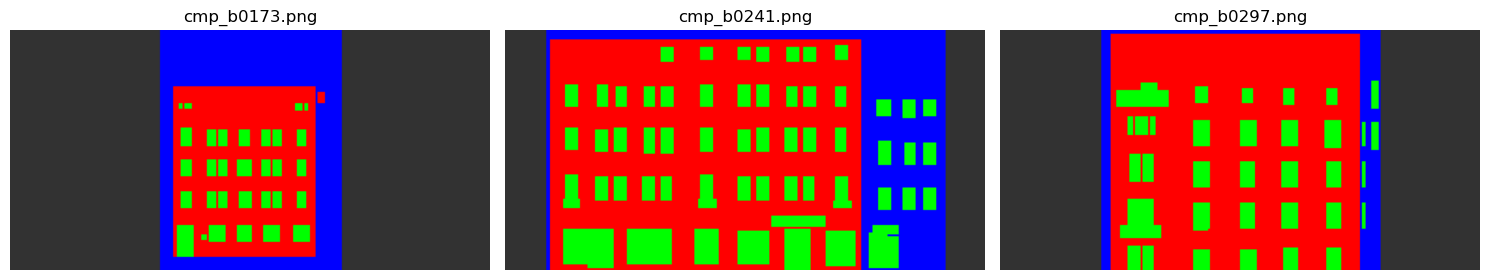

In [9]:
visualize_class_masks("../training_images/cmp_dataset/cmp_masks_preprocessed", num_images=3, max_size=256)

## Prepare self-annotated images

### Clean masks to avoid overlapping

In [12]:
input_folder = "../training_images/mapillary/self_annotated_panos"
output_mask_folder = "../training_images/mapillary/clean_masks_png"
os.makedirs(output_mask_folder, exist_ok=True)

Initially, images were mapped using 4 classes: background was divided in background and noise, but for simplicity, now I am transforming them to 3 classes. Also with this process I aim to avoid any overlapping that could have happened during the labelling process

In [ ]:
#Convert LabelMe shapes into a unified shapely polygon
def polygons_from_shapes(shapes, target_label):
    polygons = [
        Polygon(shape["points"])
        for shape in shapes
        if shape["label"] == target_label and Polygon(shape["points"]).is_valid
    ]
    if not polygons:
        return MultiPolygon()
    return unary_union(polygons)

#Convert shapely polygon to binary mask
def polygons_to_mask(polygons, height, width):
    mask = np.zeros((height, width), dtype=np.uint8)
    if polygons.is_empty:
        return mask
    if isinstance(polygons, Polygon):
        polygons = [polygons]
    elif polygons.geom_type == 'MultiPolygon':
        polygons = list(polygons.geoms)

    for poly in polygons:
        if poly.is_empty:
            continue
        exterior = np.array(poly.exterior.coords).round().astype(np.int32)
        cv2.fillPoly(mask, [exterior], 1)
        for interior in poly.interiors:
            interior_coords = np.array(interior.coords).round().astype(np.int32)
            cv2.fillPoly(mask, [interior_coords], 0)
    return mask

#Main loop: generate PNG masks from JSON annotations
for filename in os.listdir(input_folder):
    if not filename.endswith(".json"):
        continue

    with open(os.path.join(input_folder, filename), 'r') as f:
        data = json.load(f)

    h = data['imageHeight']
    w = data['imageWidth']

    #Extract polygons per class
    poly_noise = polygons_from_shapes(data["shapes"], "noise")
    poly_bg = polygons_from_shapes(data["shapes"], "background")
    poly_poro = polygons_from_shapes(data["shapes"], "porosity")
    poly_wall = polygons_from_shapes(data["shapes"], "wall")

    #Class 1: background (union of noise and background)
    clean_bg = unary_union([poly_noise, poly_bg])

    #Class 2: porosity minus background
    clean_poro = poly_poro.difference(clean_bg)

    #Class 3: wall minus background and porosity
    clean_wall = poly_wall.difference(clean_bg.union(clean_poro))

    #Convert each class to binary mask
    mask_bg = polygons_to_mask(clean_bg, h, w)
    mask_poro = polygons_to_mask(clean_poro, h, w)
    mask_wall = polygons_to_mask(clean_wall, h, w)

    #Build final mask with unique class values
    final_mask = np.zeros((h, w), dtype=np.uint8)
    final_mask[mask_bg > 0] = 1
    final_mask[mask_poro > 0] = 2
    final_mask[mask_wall > 0] = 3
    final_mask[final_mask == 0] = 1  # Assign any remaining pixels to background

    #Save as PNG
    base_name = os.path.splitext(filename)[0]
    cv2.imwrite(os.path.join(output_mask_folder, f"{base_name}.png"), final_mask)

    print(f"✔ Mask saved: {filename}")

print("Done! All masks saved.")

✔ Mask saved: 1030213207512897.json
✔ Mask saved: 1087780485669405.json
✔ Mask saved: 1088692992904317.json
✔ Mask saved: 1125146331295359.json
✔ Mask saved: 1129941494177744.json
✔ Mask saved: 1133489437062226.json
✔ Mask saved: 1139267263221502.json
✔ Mask saved: 1140119406486597.json
✔ Mask saved: 1194461634306982.json
✔ Mask saved: 1217169839114872.json
✔ Mask saved: 1237649180675104.json
✔ Mask saved: 1308124026249811.json
✔ Mask saved: 134730548704930.json
✔ Mask saved: 139011208258627.json
✔ Mask saved: 139843441502935.json
✔ Mask saved: 1420907461603962.json
✔ Mask saved: 1456789608008064.json
✔ Mask saved: 146166904194230.json
✔ Mask saved: 146519874158735.json
✔ Mask saved: 1506323073037594.json
✔ Mask saved: 157973892954789.json
✔ Mask saved: 161125445960082.json
✔ Mask saved: 161949462601268.json
✔ Mask saved: 185970209940504.json
✔ Mask saved: 193427859298662.json
✔ Mask saved: 1956367494501635.json
✔ Mask saved: 1973632079444363.json
✔ Mask saved: 198823448752201.json
✔ M

#### Preprocess images and masks

In [14]:
#Parameters
target_height = 512
target_width = 1024

#Process images
preprocess_images(
    input_folder='../training_images/mapillary/cropped_training_panos',
    output_folder='../training_images/mapillary/images_preprocessed',
    target_height=target_height,
    target_width=target_width,
    color=True,
    ext=".jpg"
)

#Process masks
preprocess_images(
    input_folder='../training_images/mapillary/clean_masks_png',
    output_folder='../training_images/mapillary/masks_preprocessed',
    target_height=target_height,
    target_width=target_width,
    color=False,
    ext=".png"
)

✔ All files from '../training_images/mapillary/cropped_training_panos' have been preprocessed and saved to '../training_images/mapillary/images_preprocessed'.
✔ All files from '../training_images/mapillary/clean_masks_png' have been preprocessed and saved to '../training_images/mapillary/masks_preprocessed'.


#### Check that images are correctly divided in 3 classes

In [ ]:
unique_classes = set()

#Iterate through all mask files in the output folder
for mask_file in os.listdir(output_mask_folder):
    mask_path = os.path.join(output_mask_folder, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    unique_classes.update(np.unique(mask))

print(f"Unique classes in the output_mask_folder: {sorted(unique_classes)}")

Unique classes in the output_mask_folder: [np.uint8(1), np.uint8(2), np.uint8(3)]


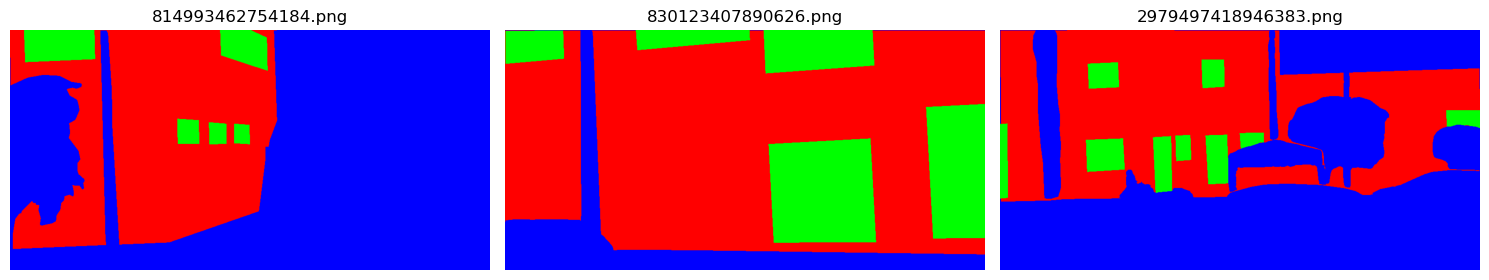

In [17]:
visualize_class_masks('../training_images/mapillary/masks_preprocessed', num_images=3, max_size=1024)

## Divide both datasets in train,test, and val directories

#### Division code

In [18]:
def create_dirs(base_dir, splits=('train', 'val')):
    for split in splits:
        (base_dir / 'images' / split).mkdir(parents=True, exist_ok=True)
        (base_dir / 'labels' / split).mkdir(parents=True, exist_ok=True)

In [ ]:
from pathlib import Path
import shutil
import random

def create_dirs(base_dir, splits=('train', 'val')):
    for split in splits:
        (base_dir / 'images' / split).mkdir(parents=True, exist_ok=True)
        (base_dir / 'labels' / split).mkdir(parents=True, exist_ok=True)

def get_image_label_pairs(images_dir, labels_dir, img_ext=".jpg", lbl_ext=".png"):
    images = sorted(images_dir.glob(f"*{img_ext}"))
    pairs = []
    for img_path in images:
        label_path = labels_dir / f"{img_path.stem}{lbl_ext}"
        if label_path.exists():
            pairs.append((img_path, label_path))
        else:
            print(f"[Warning] Label not found for {img_path.name}")
    return pairs

def copy_pairs(pairs, dest_img_dir, dest_lbl_dir):
    for img, lbl in pairs:
        shutil.copy(img, dest_img_dir / img.name)
        shutil.copy(lbl, dest_lbl_dir / lbl.name)

def split_dataset(pairs, train_ratio=0.85, val_ratio=0.15, seed=42):
    random.seed(seed)
    random.shuffle(pairs)
    n = len(pairs)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)
    return {
        'train': pairs[:n_train],
        'val': pairs[n_train:n_train + n_val],
    }

def prepare_test_set(mapillary_pairs, test_count, output_base, seed=42):
    print(f"Creating test set with {test_count} Mapillary images...")

    #Shuffle before selecting test samples
    random.seed(seed)
    random.shuffle(mapillary_pairs)

    test_img_dir = output_base / 'test_images'
    test_lbl_dir = output_base / 'test_labels'
    test_img_dir.mkdir(parents=True, exist_ok=True)
    test_lbl_dir.mkdir(parents=True, exist_ok=True)

    test_pairs = mapillary_pairs[:test_count]
    copy_pairs(test_pairs, test_img_dir, test_lbl_dir)

    #Return the remaining for training/validation
    return mapillary_pairs[test_count:]

def prepare_experiment(name, cmp_pairs, mapillary_pairs, output_base, seed=42):
    print(f"\n Preparing experiment: {name}")

    base = output_base / name
    create_dirs(base, splits=['train', 'val'])

    if name == 'cmp_only':
        data = split_dataset(cmp_pairs, seed=seed)
    elif name == 'mapillary_only':
        data = split_dataset(mapillary_pairs, seed=seed)
    elif name == 'combined':
        combined = cmp_pairs + mapillary_pairs
        data = split_dataset(combined, seed=seed)
    else:
        raise ValueError(f"Unknown experiment name: {name}")

    copy_pairs(data['train'], base / 'images' / 'train', base / 'labels' / 'train')
    copy_pairs(data['val'], base / 'images' / 'val', base / 'labels' / 'val')

    print(f"✔ {name}: {len(data['train'])} train, {len(data['val'])} val")

def run_pipeline(
    cmp_img_dir, cmp_lbl_dir,
    map_img_dir, map_lbl_dir,
    output_base,
    img_ext=".jpg", lbl_ext=".png",
    test_count=15,
    seed=42
):
    cmp_pairs = get_image_label_pairs(cmp_img_dir, cmp_lbl_dir, img_ext, lbl_ext)
    mapillary_pairs = get_image_label_pairs(map_img_dir, map_lbl_dir, img_ext, lbl_ext)

    #Create test set randomly from Mapillary pairs
    mapillary_remain = prepare_test_set(mapillary_pairs, test_count, output_base, seed)

    #Prepare splits for training/validation
    prepare_experiment("cmp_only", cmp_pairs, [], output_base, seed)
    prepare_experiment("mapillary_only", [], mapillary_remain, output_base, seed)
    prepare_experiment("combined", cmp_pairs, mapillary_remain, output_base, seed)

    print("\n All dataset splits completed.")

In [20]:
# Apply the pipeline
if __name__ == "__main__":
    run_pipeline(
        cmp_img_dir=Path("../training_images/cmp_dataset/cmp_images_preprocessed"),
        cmp_lbl_dir=Path("../training_images/cmp_dataset/cmp_masks_preprocessed"),
        map_img_dir=Path("../training_images/mapillary/images_preprocessed"),
        map_lbl_dir=Path("../training_images/mapillary/masks_preprocessed"),
        output_base=Path("../training_images/segmentation_splits"),
        img_ext=".jpg",
        lbl_ext=".png",
        test_count=15,
        seed=42
    )

Creating test set with 15 Mapillary images...

 Preparing experiment: cmp_only
✔ cmp_only: 515 train, 90 val

 Preparing experiment: mapillary_only
✔ mapillary_only: 73 train, 12 val

 Preparing experiment: combined
✔ combined: 588 train, 103 val

 All dataset splits completed.
